# Kickstarter Launches... Let's predict the outcome!
### https://www.kaggle.com/codename007/funding-successful-projects
### https://webrobots.io/kickstarter-datasets/


In [124]:
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format
import numpy as np
from numpy.random import seed, randint
import matplotlib.pyplot as plt
import seaborn as sns
import datetime    
import dateutil.parser
import zipfile
import math

#modeling 
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

#natural language processing
from textblob import TextBlob, Word

from sklearn_pandas import DataFrameMapper


plt.style.use('fivethirtyeight')
%matplotlib inline

## Get Data 

In [125]:
# The following opens a zip file, returns all the contents in the zip file (csvs), 
# and concats the files into a single dataframe

flag=0 # flag is used to to track the first instance to build an intial data frame called "data"
with zipfile.ZipFile('./Data/Kickstarter_2017-08-15T22_20_51_958Z.zip') as z:
    files = z.namelist()
    # loop through each file
    for f in files:
    #if first instance, build initial data frame called data
        with z.open(f) as f:
            if flag == 0:
                data = pd.DataFrame.from_csv(f)
                flag += 1
            else:
    #if data already exisits, we concat future csvs
                df = pd.DataFrame.from_csv(f)
                data = pd.concat([data, df])

            
# to validate that we have the data!
print data.shape
data = data.set_index([range(0, len(data))])

(169832, 32)


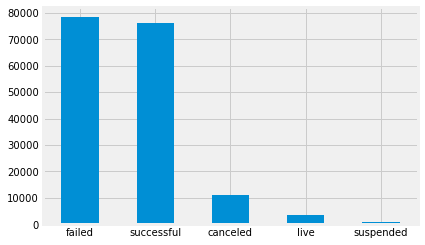

In [126]:
#exploring the target variable 'state
#take note that projects not only fail or succeed, they can also be cancelled, live, or suspended...
data.state.value_counts().plot(kind='bar', rot='0')

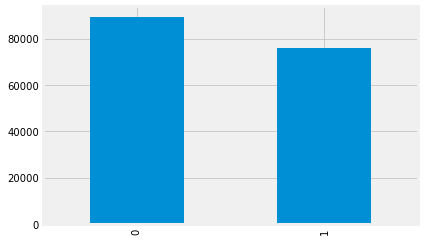

In [127]:
#let's encode the state variable
#we don't need live or suspended projects since they are ongoing
data= data[(data.state != 'live') & (data.state != 'suspended')]

# we will count a canceled project as failed
# use map to code the outcome variable
data['state_num'] = data.state.map({'failed':0, 'successful': 1, 'canceled': 0})
data.state_num.value_counts().plot(kind='bar')

## NLP Model

In [128]:
#Final preparation of data to remove null values
data = data[data.name.isnull() == False]
data = data[data.blurb.isnull() == False]
# Noticed better results when we combined the project name and the blurb
data['combined'] = data['blurb'] + ' _ ' +data['name']
# Define X and y
X = data['combined']
y = data.state_num

# Split the new DataFrame into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#Create bag of words, removing stop word and making lowercase
vect = CountVectorizer(lowercase=True, stop_words='english')
# note, using Lemmization did not help!!
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

~~~~~~~~~~~~~~~~
Depth: 60
Accuracy: 0.651139742319
Baseline: 0.460562256762
[[17735  4581]
 [ 9851  9202]]


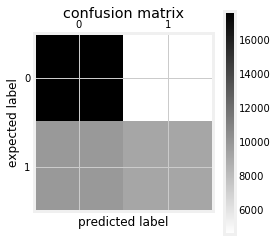

In [129]:
#run decision tree model with depth of 60 (determined 60 based on trial runs)
treeclf = DecisionTreeClassifier(max_depth=60, random_state=2)
treeclf.fit(X_train_dtm, y_train)
y_pred_class = treeclf.predict(X_test_dtm)

# Calculate accuracy.
print '~~~~~~~~~~~~~~~~'
print 'Depth: ' + str(x)
print 'Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred_class))
print 'Baseline: ' + str(y_test.mean())
print metrics.confusion_matrix(y_test, y_pred_class)

#plot the confusion matrix
plt.matshow(metrics.confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')


~~~~~~~~~~~~~~~~
Accuracy: 0.699702675917
Baseline: 0.460562256762
[[16962  5354]
 [ 7069 11984]]
0:25:26.127000


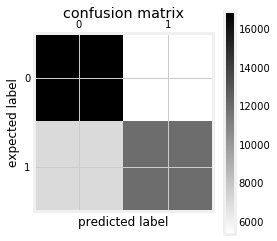

In [131]:
# Initialize a Random Forest classifier with 100 trees
from datetime import datetime
startTime = datetime.now()
print startTime
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as the only feature 
forest = forest.fit( X_train_dtm, y_train )
y_pred_class = forest.predict(X_test_dtm)
metrics.accuracy_score(y_test, y_pred_class)

# Calculate accuracy.
print '~~~~~~~~~~~~~~~~'
print 'Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred_class))
print 'Baseline: ' + str(y_test.mean())
print metrics.confusion_matrix(y_test, y_pred_class)

#plot the confusion matrix
plt.matshow(metrics.confusion_matrix(y_test, y_pred_class), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

#track how long it took the model to run
total_time = datetime.now() - startTime
print total_time